In [1]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('dataset.csv')

# Cek missing values
missing_values = data.isnull().sum()

# Cek duplikasi
duplicates = data.duplicated().sum()

# Filter numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Cek outlier menggunakan IQR
Q1 = data[numeric_columns].quantile(0.25)
Q3 = data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR)))

# Deteksi leakage: refund setelah churn
data['post_churn_refund'] = data['post_churn_refund'].fillna(0)

# Menyaring fitur yang berpotensi menyebabkan leakage
data_clean = data.drop(columns=['post_churn_refund'])

# Print results
print("Missing values:\n", missing_values)
print("\nDuplicate rows:", duplicates)
print("\nOutliers detected:\n", outliers.sum())


Missing values:
 age                   0
income                0
tenure_months         0
monthly_spend         0
support_tickets       0
has_app               0
last_login_days       0
satisfaction_score    0
region                0
contract_type         0
payment_method        0
post_churn_refund     0
churn                 0
dtype: int64

Duplicate rows: 0

Outliers detected:
 age                   0
income                0
tenure_months         0
monthly_spend         0
support_tickets       0
has_app               4
last_login_days       0
satisfaction_score    0
post_churn_refund     2
churn                 0
dtype: int64


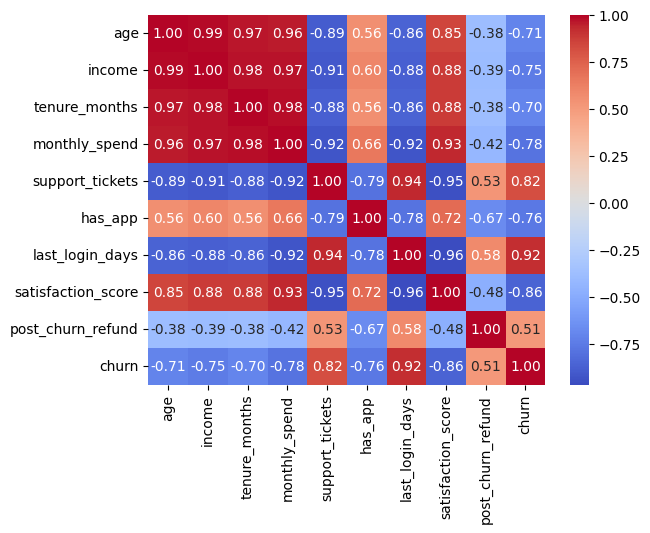

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('dataset.csv')

# Cek missing values
missing_values = data.isnull().sum()

# Cek duplikasi
duplicates = data.duplicated().sum()

# Filter numeric columns only for correlation calculation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Korelasi antar fitur numerik
correlation_matrix = data[numeric_columns].corr()

# Visualisasi korelasi dengan heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Pisahkan data dan target
X = data_clean.drop(columns=['churn'])
y = data_clean['churn']

# Pisahkan data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['age', 'income', 'monthly_spend', 'satisfaction_score']
categorical_features = ['region', 'contract_type', 'payment_method', 'has_app']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan dalam ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Gabungkan preprocessing dengan model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Buat pipeline dengan Logistic Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for RandomForest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Define the model and pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV with Stratified KFold for RandomForest
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

# Fit the model
grid_rf.fit(X_train, y_train)

# Get the best score and model
best_auc_rf = grid_rf.best_score_
best_model_rf = grid_rf.best_estimator_

print(f'Best AUC score for RandomForest: {best_auc_rf}')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/s

Best AUC score for RandomForest: nan


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income',
                                                   'monthly_spend',
                                                   'satisfaction_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
               

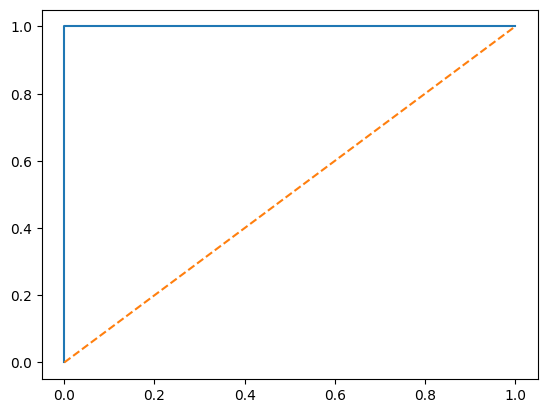

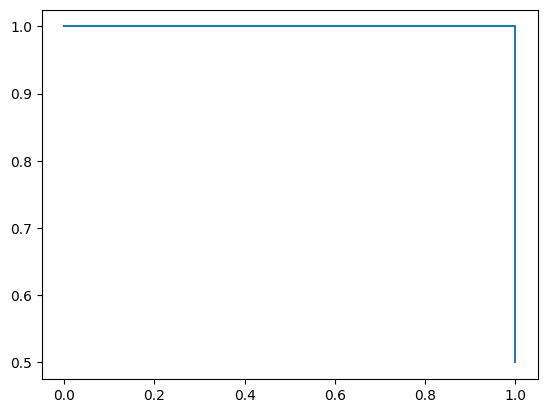

In [5]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Ensure the grid search is working and assigning the best model
if grid_rf.best_estimator_ is not None:
    best_model_rf = grid_rf.best_estimator_
    print(f"Best model found: {best_model_rf}")
else:
    print("No best model found. Please check the grid search parameters.")
    # Exit or take appropriate action
    best_model_rf = None

# If best_model_rf is valid, proceed to evaluation
if best_model_rf is not None:
    y_pred = best_model_rf.predict(X_test)
    y_proba = best_model_rf.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Classification Report
    from sklearn.metrics import classification_report
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.show()

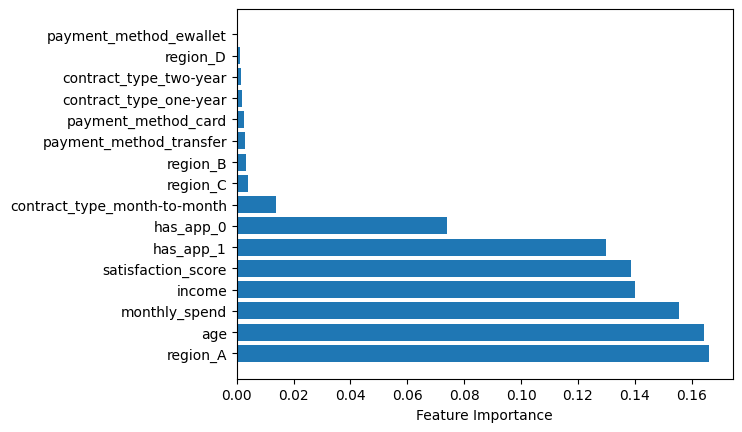

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Check if the model has 'feature_importances_' attribute
if best_model_rf is not None and hasattr(best_model_rf.named_steps['classifier'], 'feature_importances_'):
    classifier = best_model_rf.named_steps['classifier']
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]

    # If using OneHotEncoder, the column names change. Access the transformed feature names.
    if 'preprocessor' in best_model_rf.named_steps:
        # Get the column names after transformation (OneHotEncoder might have added new columns)
        preprocessor = best_model_rf.named_steps['preprocessor']
        
        # If ColumnTransformer, access the transformer step names
        cat_columns = preprocessor.transformers_[1][1].get_feature_names_out(input_features=categorical_features)
        all_columns = numeric_features + list(cat_columns)
    else:
        # For simpler models without transformations
        all_columns = X.columns

    # Visualize Feature Importance
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [all_columns[i] for i in indices])  # Using correct column names
    plt.xlabel('Feature Importance')
    plt.show()
else:
    print("Model does not have 'feature_importances_' attribute or best_model_rf is not defined.")


In [7]:
import joblib

# Simpan model final
joblib.dump(best_model_rf, 'model.pkl')

# Fungsi prediksi untuk satu data
def predict_one(data_dict):
    data = pd.DataFrame([data_dict])
    prediction = best_model_rf.predict(data)
    proba = best_model_rf.predict_proba(data)[:, 1]
    return {'prediction': int(prediction), 'proba': float(proba)}

# Uji fungsi dengan contoh pelanggan baru
new_customer = {
    'age': 28,
    'income': 25000,
    'tenure_months': 12,
    'monthly_spend': 13.0,
    'support_tickets': 3,
    'has_app': 1,
    'last_login_days': 21,
    'satisfaction_score': 3,
    'region': 'B',
    'contract_type': 'month-to-month',
    'payment_method': 'transfer'
}

print(predict_one(new_customer))

{'prediction': 0, 'proba': 0.16}


/var/folders/_t/9mkc432x7_d6trtpbb0d7b8m0000gn/T/ipykernel_24363/1193312165.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {'prediction': int(prediction), 'proba': float(proba)}
